In [3]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import numpy as np
import cv2
import csv
from glob import glob
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy
from tqdm import tqdm
import random
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Check that you're using a recent OpenCV version.
assert cv2.__version__ > '4.5', 'Please use OpenCV 4.5 or later.'

Write down the plan in words and references. We will then fill in code.

In [2]:
# Encoding: ResNeXt (conv 1-3) => Position Enc. (ref. 2107.14222) => Deep-ViT (w/ EfficientNet)
# Decoding(for unsupervised training) : HiT(low resolution stage, same # as Deep-ViT) => FCC-GAN
# Comparison : Transformer-XL 
# Classifier/MLP : MLP head (output 8) => Reconstruction module => F

# Training Steps:
# 1. Train Encoder (unsupervised): manipulate input image (ref. SiT, + rotation) and match to output
# 2. Train Comparison (unsupervised) : use different head, mix&match the 2 images (ref. BERT, ALBERT)
# 3. Train MLP (supervised) : compare output to F

# Inference Steps: Encode each image => concat. 2 images => Comparison => MLP

#offical sample code: https://www.kaggle.com/code/eduardtrulls/imc2022-training-data?scriptVersionId=92062607

# Load data

In [5]:
# copied from sample code
# Input data files are available in the read-only "../input/" directory.

# on kaggle
# src = '../input/image-matching-challenge-2022/train'

# on pc
src = './image-matching-challenge-2022/train'

val_scenes = []
for f in os.scandir(src):
    if f.is_dir():
        cur_scene = os.path.split(f)[-1]
        print(f'Found scene "{cur_scene}"" at {f.path}')
        val_scenes += [cur_scene]

Found scene "brandenburg_gate"" at ./image-matching-challenge-2022/train\brandenburg_gate
Found scene "british_museum"" at ./image-matching-challenge-2022/train\british_museum
Found scene "buckingham_palace"" at ./image-matching-challenge-2022/train\buckingham_palace
Found scene "colosseum_exterior"" at ./image-matching-challenge-2022/train\colosseum_exterior
Found scene "grand_place_brussels"" at ./image-matching-challenge-2022/train\grand_place_brussels
Found scene "lincoln_memorial_statue"" at ./image-matching-challenge-2022/train\lincoln_memorial_statue
Found scene "notre_dame_front_facade"" at ./image-matching-challenge-2022/train\notre_dame_front_facade
Found scene "pantheon_exterior"" at ./image-matching-challenge-2022/train\pantheon_exterior
Found scene "piazza_san_marco"" at ./image-matching-challenge-2022/train\piazza_san_marco
Found scene "sacre_coeur"" at ./image-matching-challenge-2022/train\sacre_coeur
Found scene "sagrada_familia"" at ./image-matching-challenge-2022/trai

Loaded 68 images.


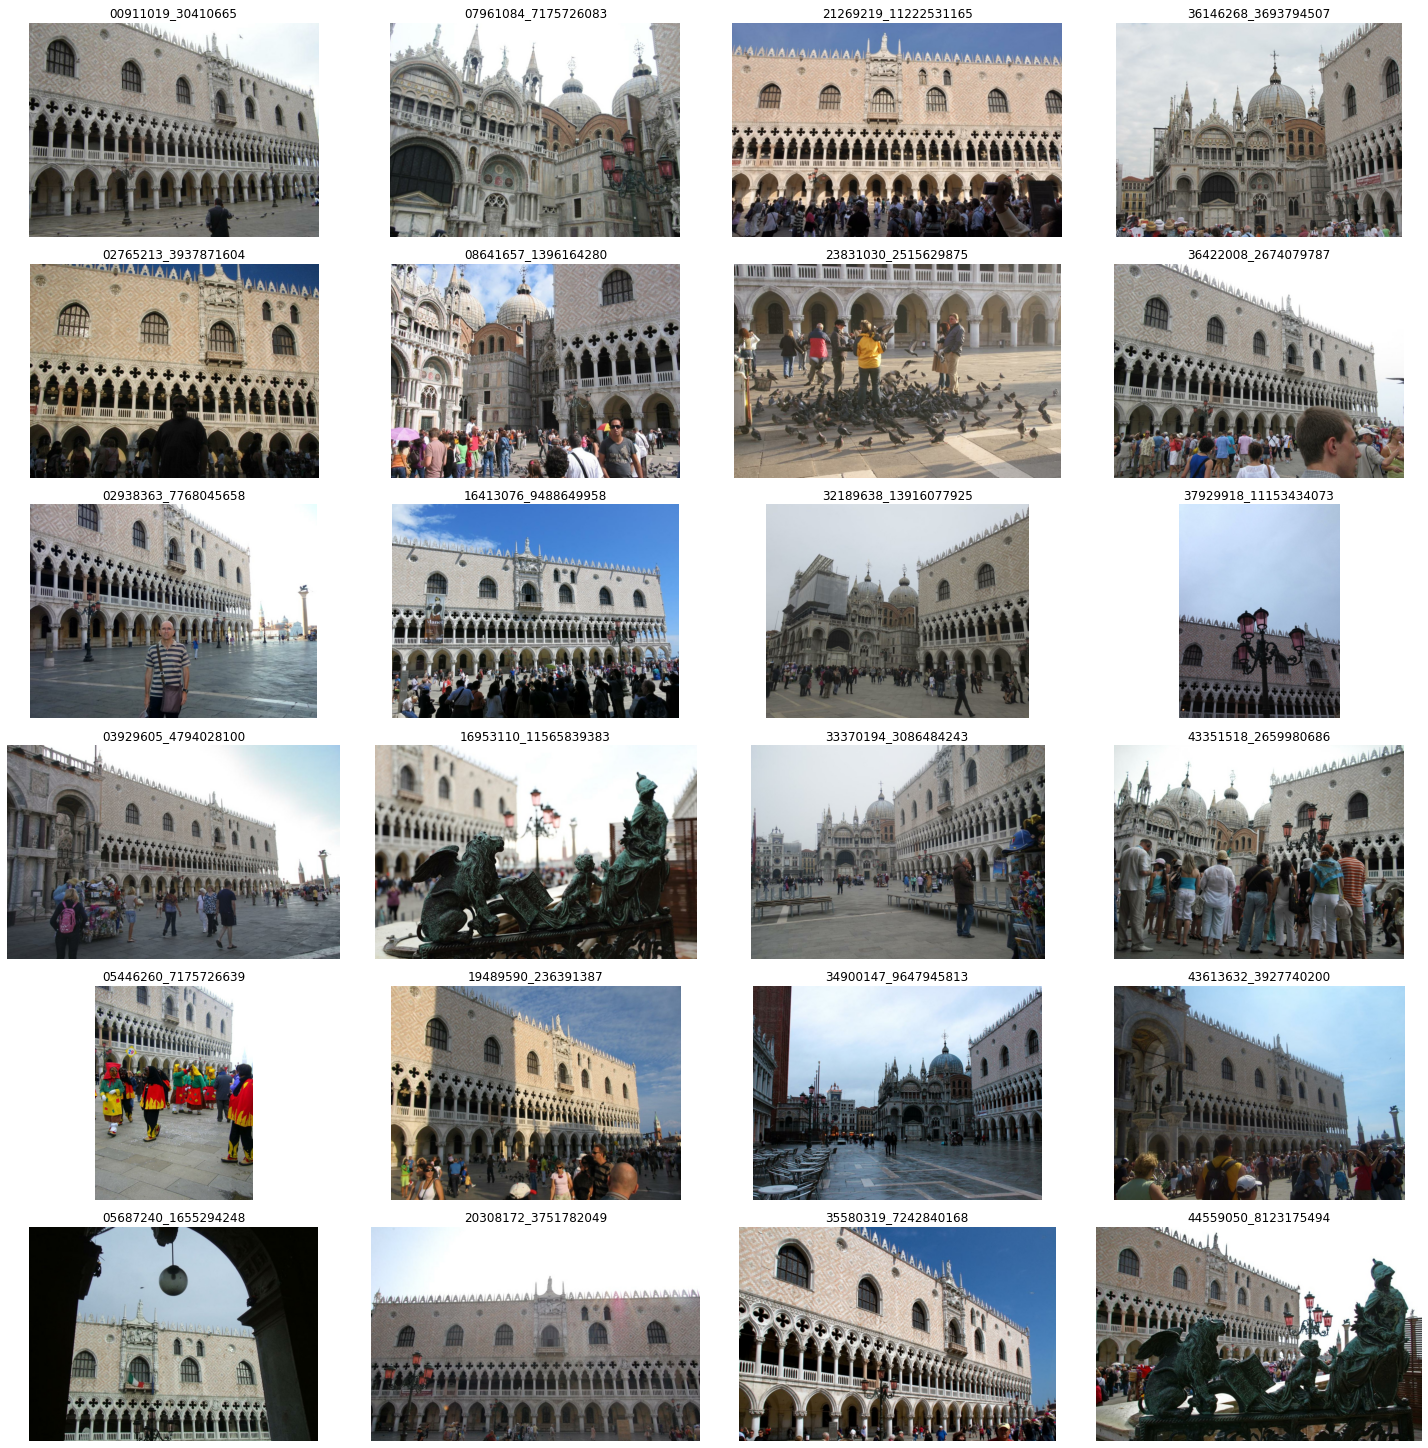

In [6]:
# Each scene in the validation set contains a list of images, poses, and pairs. Let's pick one and look at some images.

scene = 'piazza_san_marco'

images_dict = {}
for filename in glob(f'{src}/{scene}/images/*.jpg'):
    cur_id = os.path.basename(os.path.splitext(filename)[0])

    # OpenCV expects BGR, but the images are encoded in standard RGB, so you need to do color conversion if you use OpenCV for I/O.
    images_dict[cur_id] = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    
print(f'Loaded {len(images_dict)} images.')

num_rows = 6
num_cols = 4
f, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), constrained_layout=True)
for i, key in enumerate(images_dict):
    if i >= num_rows * num_cols:
        break
    cur_ax = axes[i % num_rows, i // num_rows]
    cur_ax.imshow(images_dict[key])
    cur_ax.set_title(key)
    cur_ax.axis('off')

In [ ]:
# dataset
class IMCsDataset(Dataset):
    """Image Matching Challenge 2022 dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [13]:
# pytorch data loading

def get_scene_trainloader(scene):

    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = "./image-matching-challenge-2022/train/" + scene

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                            shuffle=True, num_workers=2)

    import matplotlib.pyplot as plt
    import numpy as np

    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


    # get some random training images
    dataiter = iter(trainloader)

    print(dataiter.next())
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

    return trainloader

get_scene_trainloader("piazza_san_marco")

['n', 'e', 'c', 't']


ValueError: too many values to unpack (expected 2)

In [5]:
# ResNeXt
# github: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
# doc: https://pytorch.org/hub/pytorch_vision_resnext/
